<a href="https://colab.research.google.com/github/Stanfording/small_GAN_testing/blob/main/64_cele_small_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Goal:   Just get a small GAN running



Get the preprocessed celebHD data from google drive

In [26]:
# #Download the dataset
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1KqBRLsB0CJuQGycvaPINwaPgcGDUsAxN' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1KqBRLsB0CJuQGycvaPINwaPgcGDUsAxN" -O "proCeleba.zip" && rm -rf /tmp/cookies.txt

# #unzip the dataset
# !unzip "/content/proCeleba.zip"

# #remove unnecessary files
# !rm -rf /content/__MACOSX

Import libraries

In [27]:
from tqdm import tqdm

from torch.autograd import Variable, grad
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import os
import torch as t
import torch.nn as nn
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
from skimage import io


Set initial hyperparameters

In [28]:

img_fold_dir_64_reso = "/content/proCeleba/32"

batch_size = 64

resolution = 32

iteration = 10

critic = 1

device = t.device('cuda' if t.cuda.is_available() else 'cpu')

log_folder = "log"
!mkdir "log"
!mkdir "log/checkpoint"
!mkdir "log/sample"

mkdir: cannot create directory ‘log’: File exists
mkdir: cannot create directory ‘log/checkpoint’: File exists
mkdir: cannot create directory ‘log/sample’: File exists


Show me which gpu I am using.

In [29]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-9ee24c37-d247-4990-f5a0-a202d4ac4fc4)


Pre loading the data

In [30]:
# Define a data class for load unclassfied data.
class Get_No_Classes_Img_Dataset(Dataset):
    
    def __init__(self, folder_dir, transform = None):
        self.folder_dir = os.path.join(folder_dir)
        self.transform = transform
        self.image_list = os.listdir(self.folder_dir)
        
    def __len__(self):
        return len(os.listdir(self.folder_dir))
    
    def __getitem__(self, index):
        
        image_name = self.image_list[index]
        
        image_dir = os.path.join(self.folder_dir, image_name)
        
        image = io.imread(image_dir)
        
        if (self.transform != None):
            image = self.transform(image)
        
        return image
    

transform = transforms.ToTensor() #From Batch * Highth * Width * Channel to Batch * Channel * Highth * Width
                                  #Which is what pytorch CNN can work with.

datasets = Get_No_Classes_Img_Dataset(img_fold_dir_64_reso, transform = transform) 
                                                            # datasets[0].shape = (16,16,3)
                                                            # len(datasets) = 28000
total_data_len = len(datasets)
                                
# Viewing one data sample function:
def showOneImge(img, i):
    
    img = img.squeeze()
    
    img = transforms.ToPILImage()(img)
    plt.figure(figsize = (10,10), dpi = 10)
    plt.imshow(img)
    plt.axis('off')
    plt.savefig(f'{log_folder}/sample/{str(i + 1).zfill(6)}.png', bbox_inches='tight', pad_inches = 0)
    return


                                                            
datasets = DataLoader(datasets, batch_size = batch_size)




```
loader = iter(loader)
print(next(loader).shape) 
```
will output


```
torch.Size([batch_size, 3, resolution, resolution])
```

So data loading is ready.

What's left is keep using 

```
next(loader)
```
to access each batch of data


-------------------------------------------------

Now Designing the simple GAN network

In [31]:
"""
Define the generator
"""

class G(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.laten = nn.Linear(5, 3072)

        self.model = nn.Sequential(
            nn.Conv2d(3, 16, (3, 3), padding = "same"),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, (3, 3), padding = "same"),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, (3, 3), padding = "same"),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, (3, 3), padding = "same"),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 3, (3, 3), padding = "same"),
            nn.Sigmoid()
        )
        
        
        
    def forward(self, theInput, batch_size):
        
        x = self.laten(theInput)
        
        x = t.reshape(x, (batch_size, 3, resolution, resolution))
         
        x = self.model(x)
            
            
        return x
    
class D(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.netWork = nn.Sequential(
            nn.Conv2d(3, 16, (3, 3), padding = "same"),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d((3,3)),
            nn.Conv2d(16, 16, (3, 3), padding = "same"),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d((3,3)),
            nn.Flatten(),
            nn.Linear(144, 3),
            nn.LeakyReLU(),
            nn.Linear(3, 1))
        
    def forward(self, theInput):
        
        return self.netWork(theInput)

Testing the network

In [32]:
"""

Testing the net work:

"""

# oneImg = next(iter(datasets))[0]

# showOneImge(oneImg, 0)

# oneImg = oneImg.expand(1,3,64,64)

# print(oneImg.shape)

# print(oneImg)

# #img into G to test shape

# input_noise_example = t.randn((batch_size, 1, 1, 5))

# a = G()(input_noise_example, batch_size)
# print(a[0])
# showOneImge(a[0], 0)

# b = D()(next(loader))

# print(b.shape)

'\n\nTesting the net work:\n\n'

Gradient Penalty from wGAN, will test later.

In [33]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = t.randn((batch_size, 1, 1, 1))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    
    
    d_interpolates = D()(interpolates)
    
    
    grad_x_hat = grad(
            outputs=d_interpolates.sum(), inputs=interpolates, create_graph=True)[0]
    grad_penalty = ((grad_x_hat.view(grad_x_hat.size(0), -1)
                      .norm(2, dim=1) - 1)**2).mean()
    grad_penalty = 10 * grad_penalty
    
    return grad_penalty

Initializing the generator, discriminator, optimizer, labels, and loss.

In [34]:
generator = G().to(device)
discriminator = D().to(device)


G_optimizer = t.optim.Adam(generator.parameters(), lr = 0.001)
D_optimizer = t.optim.Adam(discriminator.parameters(), lr = 0.001)

label_real = t.ones((batch_size, 1)).to(device)
label_fake = t.zeros((batch_size, 1)).to(device)

bceLoss = nn.BCEWithLogitsLoss()

Start training

Epoch: 0: 100%|██████████| 438/438 [00:52<00:00,  8.31it/s, D_total_loss=0.000455, G_loss=0.00011, fake_score=-9.15, real_score=8.51]


epoch =  438
Epoch [0/10], Step [438/438], d_loss: 0.0005, g_loss: 0.0001, D(x): 8.51, D(G(z)): -9.15


Epoch: 2: 100%|██████████| 438/438 [00:34<00:00, 12.66it/s, D_total_loss=5.63e-5, G_loss=1.28e-5, fake_score=-11.3, real_score=10.8]


epoch =  438
Epoch [2/10], Step [438/438], d_loss: 0.0001, g_loss: 0.0000, D(x): 10.84, D(G(z)): -11.32


Epoch: 4: 100%|██████████| 438/438 [00:29<00:00, 14.78it/s, D_total_loss=1.93e-5, G_loss=3.83e-6, fake_score=-12.5, real_score=12]


epoch =  438
Epoch [4/10], Step [438/438], d_loss: 0.0000, g_loss: 0.0000, D(x): 12.04, D(G(z)): -12.55


Epoch: 6: 100%|██████████| 438/438 [00:29<00:00, 14.76it/s, D_total_loss=8.67e-6, G_loss=1.89e-6, fake_score=-13.3, real_score=12.9]


epoch =  438
Epoch [6/10], Step [438/438], d_loss: 0.0000, g_loss: 0.0000, D(x): 12.91, D(G(z)): -13.29


Epoch: 8: 100%|██████████| 438/438 [00:29<00:00, 15.01it/s, D_total_loss=4.33e-6, G_loss=1.04e-6, fake_score=-13.9, real_score=13.7]


epoch =  438
Epoch [8/10], Step [438/438], d_loss: 0.0000, g_loss: 0.0000, D(x): 13.65, D(G(z)): -13.85


Epoch: 9: 100%|██████████| 438/438 [00:29<00:00, 14.92it/s, D_total_loss=3.27e-6, G_loss=6.93e-7, fake_score=-14.3, real_score=14]


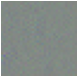

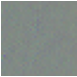

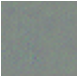

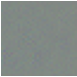

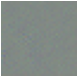

In [35]:
for i in range(iteration):

    p = tqdm(range(total_data_len // batch_size + 1)) # This is a progress bar run on each epoch
    
    loader = iter(datasets)

    for j in p:
        
    
        batchNum = str(i)
        
        #Training the D
        
        real = next(loader).to(device)
        current_batch_size, c, h, w = real.shape
        label_real = t.ones((current_batch_size, 1)).to(device)
        label_fake = t.zeros((current_batch_size, 1)).to(device)

        real_score = discriminator(real)
        d_real_loss = bceLoss(real_score, label_real)
        
        input_noise = t.randn((current_batch_size, 1, 1, 5)).to(device)
        fake = generator(input_noise, current_batch_size)
        fake_score = discriminator(fake)

        d_fake_loss = bceLoss(fake_score, label_fake)
        
        total_loss = d_real_loss + d_fake_loss

        discriminator.zero_grad()
        generator.zero_grad()
        total_loss.backward()
        D_optimizer.step()
        

        
        #Training the G
        
        if j % critic == 0:
          input_noise = t.randn((current_batch_size, 1, 1, 5)).to(device)
          fake = generator(input_noise, current_batch_size)
          fake_score = discriminator(fake)

          g_fake_loss = bceLoss(fake_score, label_fake)

          discriminator.zero_grad()
          generator.zero_grad()
          g_fake_loss.backward()
          G_optimizer.step()
        

        
        mse = "Epoch: " + batchNum
        
        p.set_description(mse)
            
        p.set_postfix(G_loss = g_fake_loss.item(), D_total_loss = total_loss.item(), real_score = real_score.mean().item(), fake_score = fake_score.mean().item())
        
        
    
    if i % 2 == 0:
        input_noise = t.randn((batch_size, 1, 1, 5)).to(device)
        images = generator(input_noise, batch_size)[0]
        
        showOneImge(images, i)
        print("epoch = ", j + 1)  
        print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'.format(i, iteration, j+1, total_data_len // batch_size + 1, total_loss.item(), g_fake_loss.item(), real_score.mean().item(), fake_score.mean().item()))      
    

    if i % 10 == 0:
      t.save(generator.state_dict(), f'{log_folder}/checkpoint/{str(i + 1).zfill(6)}_g.model')
      t.save(discriminator.state_dict(), f'{log_folder}/checkpoint/{str(i + 1).zfill(6)}_d.model')


remove log file when necessarry

In [36]:
# !rm -rf /content/log/checkpoint

# !mkdir /content/log/checkpoint

# !rm -rf /content/log/sample
# !mkdir /content/log/sample